In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
from sklearn.isotonic import IsotonicRegression

# Accurate Uncertainties for Deep Learning Using Calibrated Regression
Recalibration dataset $D = \{ (F_t(y_t) , \hat{P}(F_t(y_t))) \}_{t=1}^T$
1. Compute $F_t$ = CDF[$N(\mu_t, \sigma^2_t)]$ for t $\in$ [1, T]
2. Evalute $F_t(y_t)$ for t $\in$ [1, T]
3. compute $\hat{P}(p)=\frac{| \{y_t | F_t(y_t) \leq p, t=1...,T \}|}{T}$, where $p=F_t(y_t)$ for t $\in$ [1, T]

Fit Isotonic Regression model R to D

- Fitting regression model to D' = $\{( \hat{P}(F_t(y_t)), F_t(y_t)) \}_{t=1}^T$ seems easier for adjusting the "standard deviation" to be calibrated.
- When using D, will need to compute the CDF of the Gaussian with predicted $\mu$ and $\sigma$, transform with R, and then invert for $x_{lb}$ and $x_{ub}$. Since the CDF has been transformed, norm.ppf can no longer be used to invert. 
- When using D', can compute the ppf of the gaussian with predicted $\mu$ and $\sigma$ and evaluate it at R(lb) and R(ub). 
- I show below that $x_{lb}$ and $x_{ub}$ computed using the D' method intersect with the transformed CDF computed using D at 0.16 and 0.84. 

## Fit Predicted vs Empirical Curve $D = \{ (F_t(y_t) , \hat{P}(F_t(y_t))) \}_{t=1}^T$ with Isotonic Regression

In [17]:
# Do steps 1 & 2
def eval_cdf(df):
    df["cdf"] = df.apply(lambda x: norm.cdf(x["y_act"], x["y_pred"], x["std"]), axis=1)
    print(df.head())

In [18]:
# Do step 3
def plot_empirical_cdf(df, swap_xy=False):
    fig = plt.figure()
    plt.plot(np.arange(0, 1.01, 0.1), np.arange(0, 1.01, 0.1), color="gray", linestyle="--", label="Perfect Calibration")
    if not swap_xy:
        plt.scatter(df.cdf.values, df.p_hat.values, alpha=0.1)
        plt.ylabel("Empirical Cumulative Distribution")
        plt.xlabel("Predicted Cumulative Distribution")
    else:
        plt.scatter(df.p_hat.values, df.cdf.values, alpha=0.1)
        plt.xlabel("Empirical Cumulative Distribution")
        plt.ylabel("Predicted Cumulative Distribution")
    plt.title("Estimating Cumulative Density of Forecast")
    plt.legend();
    plt.show()
    
def compute_empirical_cdf(df, swap_xy=False):
    p_hat = []
    T = len(df)
    for index, row in df.iterrows():
        p = row["cdf"]
        p_hat.append((df["cdf"] <= p).sum()/T)
    df["p_hat"] = p_hat

    plot_empirical_cdf(df, swap_xy)

### Randomly (uniform) select the true pick between -0.75 and 0.75. Set the predicted pick to 0 and change the std (but leave constant)

      y_act  y_pred  std       cdf
0  0.157286     0.0  1.0  0.562490
1  0.035338     0.0  1.0  0.514095
2 -0.676443     0.0  1.0  0.249380
3 -0.519246     0.0  1.0  0.301795
4 -0.384795     0.0  1.0  0.350195


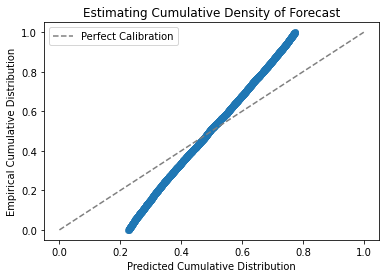

In [36]:
# Every pick is within 1 std (1.0)
y_act = np.random.uniform(-0.75, 0.75, 10000)
y_pred = np.zeros_like(y_act)
pred_stds = np.ones_like(y_act)
df = pd.DataFrame({"y_act":y_act, "y_pred":y_pred, "std":pred_stds})
df.head()

eval_cdf(df)
compute_empirical_cdf(df)

In [37]:
df.cdf.describe()

count    10000.000000
mean         0.496504
std          0.163127
min          0.226635
25%          0.349970
50%          0.493833
75%          0.638758
max          0.773338
Name: cdf, dtype: float64

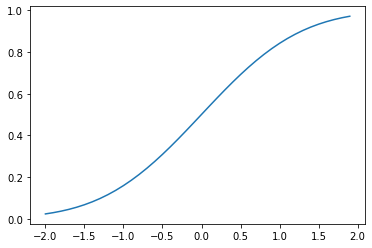

In [38]:
#Example CDF
plt.plot(np.arange(-2, 2, 0.1), norm.cdf(np.arange(-2, 2, 0.1), df["y_pred"].iloc[0], df["std"].iloc[0]))

When the standard deviation is too large, the CDF(y_act) will be restricted and never get down to 0 or up to 1. 

      y_act  y_pred  std       cdf
0  0.311167     0.0  0.5  0.733139
1 -0.270847     0.0  0.5  0.294015
2 -0.530183     0.0  0.5  0.144489
3  0.091510     0.0  0.5  0.572609
4  0.157436     0.0  0.5  0.623570


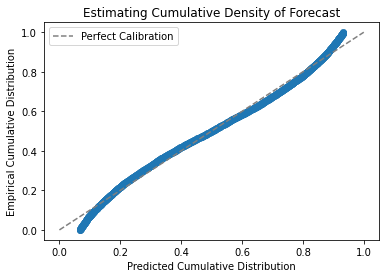

In [39]:
# Every pick is within 2 std (0.5)
y_act = np.random.uniform(-0.75, 0.75, 10000)
y_pred = np.zeros_like(y_act)
pred_stds = np.full_like(y_act, 0.5)
df = pd.DataFrame({"y_act":y_act, "y_pred":y_pred, "std":pred_stds})
df.head()

eval_cdf(df)
compute_empirical_cdf(df)

In [40]:
df.cdf.describe()

count    10000.000000
mean         0.499911
std          0.283469
min          0.066867
25%          0.227785
50%          0.501803
75%          0.771551
max          0.933060
Name: cdf, dtype: float64

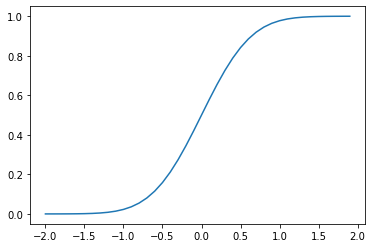

In [41]:
plt.plot(np.arange(-2, 2, 0.1), norm.cdf(np.arange(-2, 2, 0.1), df["y_pred"].iloc[0], df["std"].iloc[0]))

"Goldilocks std" - the CDF(min(y_act)) is ~0 and CDF(max(y_act)) is ~1.0

      y_act  y_pred   std       cdf
0 -0.420848     0.0  0.25  0.046149
1 -0.254327     0.0  0.25  0.154503
2  0.533756     0.0  0.25  0.983620
3 -0.697090     0.0  0.25  0.002649
4 -0.170023     0.0  0.25  0.248224


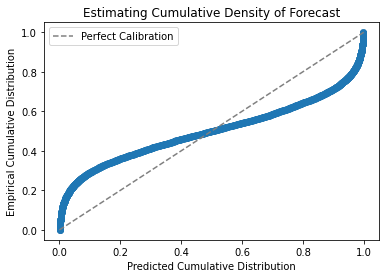

In [42]:
# Every pick is within the 3 std (0.25)
y_act = np.random.uniform(-0.75, 0.75, 10000)
y_pred = np.zeros_like(y_act)
pred_stds = np.full_like(y_act, 0.25)
df = pd.DataFrame({"y_act":y_act, "y_pred":y_pred, "std":pred_stds})
df.head()

eval_cdf(df)
compute_empirical_cdf(df)

In [43]:
df.cdf.describe()

count    10000.000000
mean         0.499985
std          0.395750
min          0.001356
25%          0.063870
50%          0.501849
75%          0.932757
max          0.998650
Name: cdf, dtype: float64

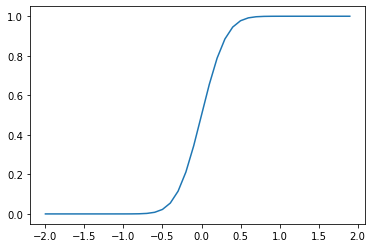

In [44]:
plt.plot(np.arange(-2, 2, 0.1), norm.cdf(np.arange(-2, 2, 0.1), df["y_pred"].iloc[0], df["std"].iloc[0]))

   y_act    y_pred  std       cdf
0    0.0 -0.243836  0.5  0.687109
1    0.0  0.004568  0.5  0.496355
2    0.0 -0.682820  0.5  0.913974
3    0.0  0.511397  0.5  0.153203
4    0.0 -0.121677  0.5  0.596135


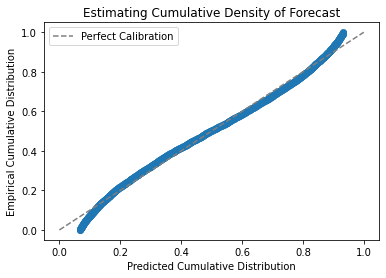

In [47]:
# Every pick is within 2 std (0.5) - switch y_act (constant) and y_pred (random) - same result
y_pred = np.random.uniform(-0.75, 0.75, 10000)
y_act = np.zeros_like(y_act)
pred_stds = np.full_like(y_act, 0.5)
df = pd.DataFrame({"y_act":y_act, "y_pred":y_pred, "std":pred_stds})
df.head()

eval_cdf(df)
compute_empirical_cdf(df)

If the standard deviations are too small, then the CDF(y_act) will saturate towards the extreme values . 

### Randomly (uniform) select the true pick between -0.75 and 0 to resitrict the domain. Set the predicted pick to 0 and go with STD of 0.5 (close to being well calibrated when uniformly sampled on the entire range)

      y_act  y_pred  std       cdf
0 -0.394843     0.0  0.5  0.214855
1 -0.679020     0.0  0.5  0.087225
2 -0.043702     0.0  0.5  0.465175
3 -0.262740     0.0  0.5  0.299625
4 -0.126524     0.0  0.5  0.400116


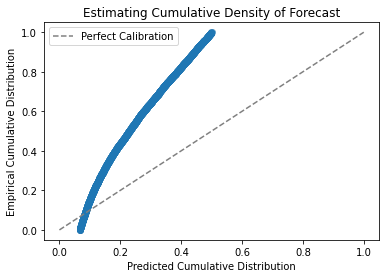

In [45]:
# Every pick is within 2 std (0.5)
y_act = np.random.uniform(-0.75, 0, 10000)
y_pred = np.zeros_like(y_act)
pred_stds = np.full_like(y_act, 0.5)
df = pd.DataFrame({"y_act":y_act, "y_pred":y_pred, "std":pred_stds})
df.head()

eval_cdf(df)
compute_empirical_cdf(df)

Too many picks on the lower half of the CDF - not uniformly distributed across the possible CDF values. Would indicate some systematic bias in the deviation of the true pick and predicted pick? 

      y_act  y_pred  std       cdf
0  0.393891     0.0  0.5  0.784588
1  0.206475     0.0  0.5  0.660178
2  0.342258     0.0  0.5  0.753175
3  0.256212     0.0  0.5  0.695823
4  0.650315     0.0  0.5  0.903307


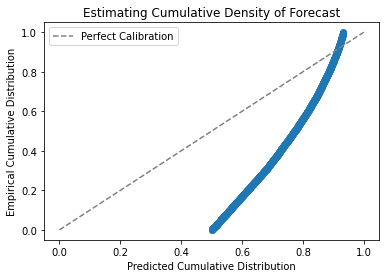

In [46]:
# Every pick is within 2 std (0.5)
y_act = np.random.uniform(0, 0.75, 10000)
y_pred = np.zeros_like(y_act)
pred_stds = np.full_like(y_act, 0.5)
df = pd.DataFrame({"y_act":y_act, "y_pred":y_pred, "std":pred_stds})
df.head()

eval_cdf(df)
compute_empirical_cdf(df)